In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import os, sys, pathlib, random, time, pickle, copy
from tqdm import tqdm

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [3]:
import torch.optim as optim
from torch.utils import data

In [4]:
train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
test_transform = transforms.Compose([
            transforms.ToTensor(),
        ])

train_dataset = datasets.FashionMNIST(root="../../../../../_Datasets/FMNIST/", train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root="../../../../../_Datasets/FMNIST/", train=False, download=True, transform=test_transform)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=50, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=50, shuffle=False, num_workers=2)

In [6]:
## demo of train loader
xx, yy = iter(train_loader).next()
xx.shape

torch.Size([50, 1, 28, 28])

# Model

## MLP-Mixer 

In [7]:
class MlpBLock(nn.Module):
    
    def __init__(self, input_dim, hidden_layers_ratio=[2], actf=nn.GELU):
        super().__init__()
        self.input_dim = input_dim
        #### convert hidden layers ratio to list if integer is inputted
        if isinstance(hidden_layers_ratio, int):
            hidden_layers_ratio = [hidden_layers_ratio]
            
        self.hlr = [1]+hidden_layers_ratio+[1]
        
        self.mlp = []
        ### for 1 hidden layer, we iterate 2 times
        for h in range(len(self.hlr)-1):
            i, o = int(self.hlr[h]*self.input_dim),\
                    int(self.hlr[h+1]*self.input_dim)
            self.mlp.append(nn.Linear(i, o))
            self.mlp.append(actf())
        self.mlp = self.mlp[:-1]
        
        self.mlp = nn.Sequential(*self.mlp)
        
    def forward(self, x):
        return self.mlp(x)

In [8]:
MlpBLock(2, [3,4])

MlpBLock(
  (mlp): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): GELU()
    (2): Linear(in_features=6, out_features=8, bias=True)
    (3): GELU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [9]:
# class MixerBlock(nn.Module):
    
#     def __init__(self, patch_dim, channel_dim):
#         super().__init__()
        
#         self.ln0 = nn.LayerNorm(channel_dim)
#         self.mlp_patch = MlpBLock(patch_dim, [2])
#         self.ln1 = nn.LayerNorm(channel_dim)
#         self.mlp_channel = MlpBLock(channel_dim, [2])
    
#     def forward(self, x):
#         ## x has shape-> N, nP, nC/hidden_dims; C=Channel, P=Patch
        
#         ######## !!!! Can use same mixer on shape of -> N, C, P;
        
#         #### mix per patch
#         y = self.ln0(x)
#         y = torch.swapaxes(y, -1, -2)
#         y = self.mlp_patch(y)
#         y = torch.swapaxes(y, -1, -2)
#         x = x+y
        
#         #### mix per channel 
#         y = self.ln1(x)
#         y = self.mlp_channel(y)
#         x = x+y
#         return x

In [10]:
# class MlpMixer(nn.Module):
    
#     def __init__(self, image_dim:tuple, patch_size:tuple, hidden_expansion:float, num_blocks:int, num_classes:int):
#         super().__init__()
        
#         self.img_dim = image_dim ### must contain (C, H, W) or (H, W)
        
#         ### find patch dim
#         d0 = int(image_dim[-2]/patch_size[0])
#         d1 = int(image_dim[-1]/patch_size[1])
#         assert d0*patch_size[0]==image_dim[-2], "Image must be divisible into patch size"
#         assert d0*patch_size[1]==image_dim[-1], "Image must be divisible into patch size"
# #         self.d0, self.d1 = d0, d1 ### number of patches in each axis
#         __patch_size = patch_size[0]*patch_size[1]*image_dim[0] ## number of channels in each patch
    
#         ### find channel dim
#         channel_size = d0*d1 ## number of patches
        
#         ### after the number of channels are changed
#         init_dim = __patch_size
#         final_dim = int(patch_size[0]*patch_size[1]*hidden_expansion)
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
#         #### rescale the patches (patch wise image non preserving transform, unlike bilinear interpolation)
#         self.channel_change = nn.Linear(init_dim, final_dim)
#         print(f"MLP Mixer : Channes per patch -> Initial:{init_dim} Final:{final_dim}")
        
        
#         self.channel_dim = final_dim
#         self.patch_dim = channel_size
        
#         self.mixer_blocks = []
#         for i in range(num_blocks):
#             self.mixer_blocks.append(MixerBlock(self.patch_dim, self.channel_dim))
#         self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        
#         self.linear = nn.Linear(self.patch_dim*self.channel_dim, num_classes)
        
        
#     def forward(self, x):
#         bs = x.shape[0]
#         x = self.unfold(x).swapaxes(-1, -2)
#         x = self.channel_change(x)
#         x = self.mixer_blocks(x)
#         x = self.linear(x.view(bs, -1))
#         return x

In [11]:
# mixer = MlpMixer((1, 28, 28), (4, 4), hidden_expansion=2, num_blocks=1, num_classes=10)
# mixer

In [12]:
# mixer(torch.randn(3, 1, 28, 28))

## Patch Mixer

In [13]:
fold_params = dict(kernel_size=4, dilation=1, padding=0, stride=4)

fold = nn.Fold(output_size=(28,28), **fold_params)
unfold = nn.Unfold(**fold_params)

In [14]:
input_ones = torch.ones(3, 1, 28, 28)

In [15]:
# divisor = fold(unfold(input_ones))
unfold(input_ones).shape

torch.Size([3, 16, 49])

In [16]:
fold(unfold(input_ones)).shape

torch.Size([3, 1, 28, 28])

In [17]:
class PatchMixerBlock(nn.Module):
    
    def __init__(self, patch_size, num_channel):
        super().__init__()
        self.patch_size = patch_size
        
#         self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
        ps = None
        if isinstance(patch_size, int):
            ps = patch_size**2
        else:
            ps = patch_size[0]*patch_size[1]
        ps = ps*num_channel
        
        self.ln0 = nn.LayerNorm(ps)
        self.mlp_patch = MlpBLock(ps, [2])
        
#         self.fold = nn.Fold(kernel_size=patch_size, stride=patch_size)
    
    def forward(self, x):
        ## x has shape-> N, C, H, W; C=Channel
        
        sz = x.shape
        
        y = nn.functional.unfold(x, 
                                 kernel_size=self.patch_size, 
                                 stride=self.patch_size
                                )
        #### mix per patch
        y = torch.swapaxes(y, -1, -2)
        y = self.ln0(y) 
        y = self.mlp_patch(y)
        y = torch.swapaxes(y, -1, -2)
        
        y = nn.functional.fold(y, (sz[-2], sz[-1]), 
                               kernel_size=self.patch_size, 
                               stride=self.patch_size
                              )
        x = x+y
        return x

In [18]:
pmb = PatchMixerBlock(4, 2)
pmb

PatchMixerBlock(
  (ln0): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
  (mlp_patch): MlpBLock(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): GELU()
      (2): Linear(in_features=64, out_features=32, bias=True)
    )
  )
)

In [19]:
pmb(torch.randn(1, 2, 28,28)).shape

torch.Size([1, 2, 28, 28])

In [20]:
def get_factors(n):
    facts = []
    for i in range(2, n+1):
        if n%i == 0:
            facts.append(i)
    return facts

class PatchMlpMixer(nn.Module):
    
    def __init__(self, image_dim:tuple, patch_sizes:tuple, input_scale:float, num_blocks:int, num_classes:int):
        super().__init__()
        
        self.img_dim = image_dim ### must contain (C, H, W)
        
        scaled_img_size = int(image_dim[-2]*input_scale), int(image_dim[-1]*input_scale)
        if input_scale==1:
            self.scaler = lambda x: x
        else:
            self.scaler = nn.UpsamplingBilinear2d(size=scaled_img_size)
        
        print(f"Scaled Image Size: {scaled_img_size}")
        print(f"Prime factors of image size")
        print(f"H -> {get_factors(scaled_img_size[0])}")
        print(f"W -> {get_factors(scaled_img_size[1])}")
        
        ### find number of channel for input, the channel is 
        num_channel = image_dim[0]
        
        self.mixer_blocks = []
        for i in range(num_blocks):
            for ps in patch_sizes:
                self.mixer_blocks.append(PatchMixerBlock(ps, num_channel))
                
        self.mixer_blocks = nn.Sequential(*self.mixer_blocks)
        self.linear = nn.Linear(scaled_img_size[0]*scaled_img_size[1]*num_channel, num_classes)
    
    def forward(self, x):
        bs = x.shape[0]
        x = self.scaler(x)
        x = self.mixer_blocks(x)
        x = self.linear(x.view(bs, -1))
        return x

In [21]:
patch_mixer = PatchMlpMixer((1, 28, 28), patch_sizes=[4, 7], input_scale=1, num_blocks=5, num_classes=10)

Scaled Image Size: (28, 28)
Prime factors of image size
H -> [2, 4, 7, 14, 28]
W -> [2, 4, 7, 14, 28]


In [22]:
patch_mixer(torch.randn(3, 1, 28, 28)).shape

torch.Size([3, 10])

#### Final Model

In [23]:
model = PatchMlpMixer((1, 28, 28), patch_sizes=[4, 7], input_scale=1, num_blocks=5, num_classes=10)
model = model.to(device)

Scaled Image Size: (28, 28)
Prime factors of image size
H -> [2, 4, 7, 14, 28]
W -> [2, 4, 7, 14, 28]


In [24]:
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  62615


## Training

In [25]:
 ## debugging to find the good classifier/output distribution.
model_name = 'patch_mixer_fmnist_v1'

In [26]:
EPOCHS = 20
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [27]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [28]:
best_acc = -1
def test(epoch):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

In [29]:
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
resume = False

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('./models'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load(f'./models/{model_name}.pth')
    model.load_state_dict(checkpoint['model'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

In [30]:
# ### Train the whole damn thing

# for epoch in range(start_epoch, start_epoch+EPOCHS): ## for 200 epochs
#     train(epoch)
#     test(epoch)
#     scheduler.step()

In [31]:
best_acc

-1

In [32]:
checkpoint = torch.load(f'./models/{model_name}.pth')
best_acc = checkpoint['acc']
start_epoch = checkpoint['epoch']

best_acc, start_epoch

(87.2, 0)

In [33]:
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [34]:
model.to(device)
print("")

In [72]:
xx, yy = iter(train_loader).next()
xx = xx.to(device)

In [73]:
xx_flows = [xx, ]

yout = xx
optimizer.zero_grad()
with torch.no_grad():
    for i in range(len(model.mixer_blocks)):
        yout = model.mixer_blocks[i](yout)
        print(yout.shape)
        xx_flows.append(yout.data)

torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])


In [77]:
### plot the dynamics
N = 10
print(f"{N}/{len(xx)}")

10/50


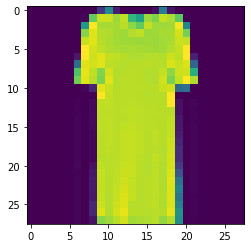

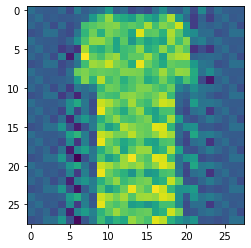

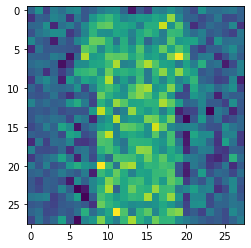

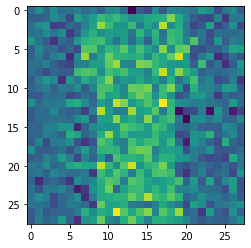

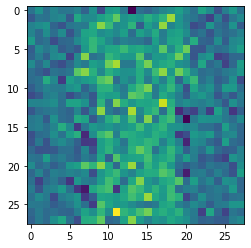

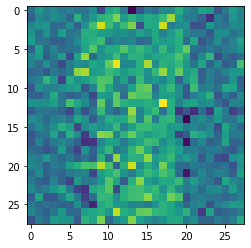

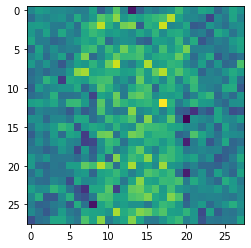

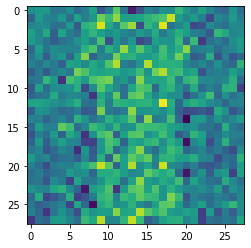

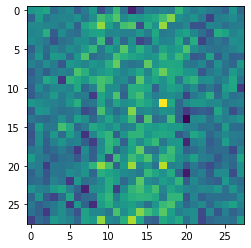

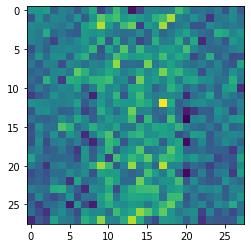

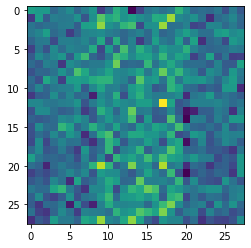

tensor(3)


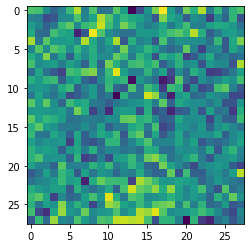

In [78]:
for i in range(len(xx_flows)):
    plt.imshow(xx_flows[i][N].cpu().numpy().reshape(28, 28))
    plt.show()
print(yy[N])
## Target image for given class
imgf = model.linear.weight.data[yy[N]].cpu().numpy().reshape(28, 28)
plt.imshow(imgf)
plt.show()